# The folowing script Generates training data for a GAN
 - The script has two methods for generating training data for a GAN from the cleaned and annoated world championships data.
 - The generated training data is a structure containing arrays shaped 16x16 and corresponding class number.

In [7]:
# Import neccessary dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
# Allows us to create graph objects for making more customized plots
import plotly.graph_objects as go
from matplotlib import pyplot as plt

from os import getcwd as wd # get the working directory

In [8]:
csv_path = f"{wd()}/data/world_championships_data.csv"
df = pd.read_csv(csv_path, index_col = 0)
df.head()


/tmp/ipykernel_323621/2848796252.py:2: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



,id,class,time_ms,success,weightclass,name,country,weight,x0,y0,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
15,0,start,391633.333333,1,109+,TOYCHYYEV,TKM,180,0.492270,0.249343,...,-0.103702,0.250496,0.427865,-0.001709,-0.273670,0.232539,0.559647,0.001709,-0.244762,0.213154
16,0,start,391666.666667,1,109+,TOYCHYYEV,TKM,180,0.492256,0.260386,...,-0.080179,0.323355,0.429044,-0.002347,-0.221434,0.305030,0.559634,0.002347,-0.206907,0.290510
17,0,start,391700.000000,1,109+,TOYCHYYEV,TKM,180,0.492122,0.273022,...,-0.052037,0.389390,0.428880,-0.001509,-0.168077,0.369838,0.559187,0.001509,-0.164393,0.360186
18,0,start,391733.333333,1,109+,TOYCHYYEV,TKM,180,0.492107,0.275419,...,-0.041674,0.448591,0.428852,-0.001392,-0.153025,0.428470,0.559413,0.001392,-0.144922,0.422875
19,0,start,391766.666667,1,109+,TOYCHYYEV,TKM,180,0.492137,0.284583,...,-0.045571,0.501953,0.428794,-0.001289,-0.160241,0.481376,0.559285,0.001289,-0.152675,0.479406


In [4]:
# column names used in the 
column_order = [16,14,12,24,26,28,8,2,5,7,27,25,23,11,13,15] 
column_order_str = [f'{dimension}{item}' for item in column_order for dimension in ["y"]]

# Method No 1 - Generate data for 3 clases based on finding the peak point in the lift.

768 - Total number of training images generated.
0


/tmp/ipykernel_323621/3064060002.py:94: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



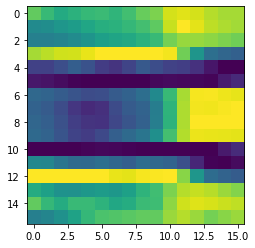

1


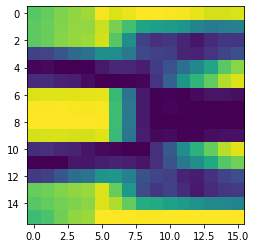

2


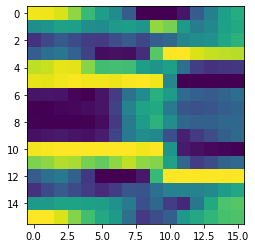

0


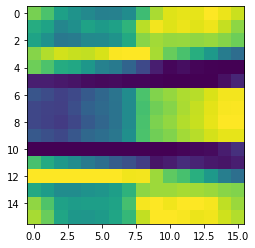

1


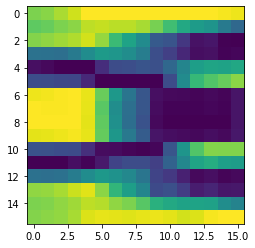

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def pad_data(im_data,no_of_rows,append_part = "start"):
    """
    Function padd the data by duplicating start or end rows in an array and outputs the data in the standard 16x16 output size.
    """
    if append_part == "start":
        im_data_padding = np.repeat(im_data[:1],no_of_rows,axis=0)
        im_data = np.vstack([im_data_padding,im_data])
    if append_part == "end":
        im_data_padding = np.repeat(im_data[-1:],no_of_rows,axis=0)
        im_data = np.vstack([im_data,im_data_padding])
    return im_data

def gradients_scale(npArray, order = 1):
    """
    Fucntion used to find the gradient of the data and the scale the data.
    """
    while order > 0:
        npArray = np.gradient(npArray,axis = 0)
        order =-1

    npArray = npArray.transpose()
    npArray = scaler.fit_transform(npArray)
    
    return npArray

def smooth(y):
    """
    Function used for filtering the data with a convolution.
    """
    box_pts = 6
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same') # if you use valid, then returns shortend array by the size of the box
    return y_smooth

def input_output_image_given_id(df_orig,window = 16):
    
    input_list = []
    output_list = []

    for lift_id in df_orig.id.unique():
        df = df_orig[df_orig.id==lift_id].reset_index() # dataframe for the lift_id and the feature columns
        
        # !!!!! filter the signals with a convolution, column (timewise axis) !!!!!
        try:
            df[column_order_str] = df[column_order_str].apply(smooth,axis=0)
        except Exception as e:
            print(e)
        
        peak = df["y0"].max()
        index_value = df[df["y0"] == peak].index.to_list()[0] # find peak index value, that is used for alignement
        df = df[column_order_str]
        
        
        # !!!!! Generate the matrices !!!!!
        # Extend
        extend = df.loc[index_value-24:index_value-9].to_numpy(dtype="float32")
        extend_len = extend.shape[0]
       
        # Overturn
        overturn = df.loc[index_value-8:index_value+7].to_numpy(dtype="float32")
        overturn_len = overturn.shape[0]

        # Catch
        catch = df.loc[index_value+8:index_value+23].to_numpy(dtype="float32")
        catch_len = catch.shape[0]
        
        
        # !!!!! Process the data and ensure the final output is of desired dimensions !!!!!
        if (extend_len < window) & (extend_len > 14) : # data needs to be padded
            extend = pad_data(extend,abs(window - extend_len),"start")
            extend_len = extend.shape[0]

        if (catch_len < window) & (catch_len > 14) : # data needs to be padded
            catch = pad_data(catch,abs(window - catch_len),"end")
            catch_len = extend.shape[0]
        
        if extend_len == window: 
            input_list.append(gradients_scale(extend)) 
            output_list.append([np.array(0)]) 
        
        if overturn_len == window: 
            input_list.append(gradients_scale(overturn)) 
            output_list.append([np.array(1)]) 
       
        if catch_len == window: 
            input_list.append(gradients_scale(catch)) 
            output_list.append([np.array(2)]) 
        
    
    print(f"{np.shape(input_list)[0]} - Total number of training images generated.")
    return np.array([input_list,np.array([output_list])])


lift_data = []
lift_data = input_output_image_given_id(df)


for i in range(0,100,1)[:5]:
  category = lift_data[1][0][i][0]
  print(category)
  plt.imshow(lift_data[0][i])
  plt.show()

### Save the numpy object for use in the GAN

In [437]:
name = "filt_center_method"
path = f'{wd()}/data/{name}.npy'
np.save(path,lift_data)

# Method No 2 - Generate training data based on all the clases available in each lift

size of each labled bit will be 16 x 16

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def smooth(y):
    box_pts = 6
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same') # if you use valid, then returns shortend array by the size of the box
    return y_smooth

def gradients(npArray, order = 2):
    while order > 0:
        npArray = np.gradient(npArray,axis = 0)
        order =-1
    return npArray

def input_output_image_given_id(df_orig,set_element_size = 16):
    
    input_list = []
    output_list = []
    class_elem_dict = {'start':0, 'extension':1, 'overturn':2, 'catch':3, 'end':4}
    for lift_id in df_orig.id.unique():
        
        filterId = df_orig.id==lift_id
        df = df_orig[filterId].reset_index()
        
        # !!!!! filter the signals !!!!!
        try:
            df[column_order_str] = df[column_order_str].apply(smooth,axis=0)
        except Exception as e:
            print(e)
        
        for class_lable in df_orig["class"].unique():
            filterClass = df["class"]==class_lable
            try:
                start,end = df[filterClass].first_valid_index(),df[filterClass].last_valid_index()

                lift_element = df[filterClass][column_order_str].to_numpy(dtype = "float32")
                
                lift_element_len =  lift_element.shape[0]

                
                if lift_element_len != set_element_size:
                    # print(class_lable,start,end)
                    diff = abs(set_element_size - lift_element_len)
                    # print("diff",diff)

                    if lift_element_len>set_element_size: # !!! LONG
                        # print("long")
                        start = start + diff
                        lift_element = df.loc[start:end,column_order_str].to_numpy(dtype = "float32")
                        # print("shape",lift_element.shape[0])
                    else:                                 # !!! SHORT
                        # print("short")
                        if (start-diff)<0:
                            end = end + diff
                            lift_element = df.loc[start:end,column_order_str].to_numpy(dtype = "float32")
                            # print("shape",lift_element.shape[0])
                        else:
                            start = start - diff
                            lift_element = df.loc[start:end,column_order_str].to_numpy(dtype = "float32")
                            # print("shape",lift_element.shape[0])
                    
                    

                lift_element = gradients(lift_element) # get gradient
                lift_element = lift_element.transpose() # flip
                lift_element = scaler.fit_transform(lift_element) # min_max norm
                
                
                input_list.append(lift_element)
                output_list.append([np.array(class_elem_dict[class_lable],dtype="uint8")])
            except:
                class_lable

    print(f"{np.shape(input_list)[0]} - Total number of training images generated.")

    return np.array([input_list,np.array([output_list])])


lift_data = input_output_image_given_id(df)

for i in range(0,100,1)[:5]:
  category = lift_data[1][0][i][0]
  print(category)
  plt.imshow(lift_data[0][i])
  plt.show()

878 - Total number of training images.


/tmp/ipykernel_323621/2514145359.py:77: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



### Save the numpy object for use in the GAN

In [ ]:
name = "filt_window_method"
path = f'{wd()}/data/{name}.npy'
np.save(path,lift_data)